# GridWorld env

## To do:
- 

In [1]:
import numpy as np
import random
from copy import deepcopy
import gym
from gym import spaces
import matplotlib.pyplot as plt

# Environment

In [699]:
class GridWorld(gym.Env):
    
    def __init__(self, n, goal=None, holes=None):
        '''
         env = GridWorld(n, goal, holes=None)
         
         Creates a 2D GridWorld environment of size (n,n).
         
         Coors are (row,col).
         Actions are indexed 0-3
              2
            3 + 1
              0
         goal is a list of tuples for the goal state ([row,col], r)
        '''
        super().__init__()
        self.n = n
        n_actions = 4
        self.P = np.array([[1,0],[0,1],[-1,0],[0,-1]], dtype=int)
        self.action_space = spaces.Discrete(n_actions)
        self.observation_space = spaces.MultiDiscrete((self.n,self.n)) #spaces.Discrete(self.n**2)
        self.terminal = []
        self.R = np.zeros(self.observation_space.nvec)
        if goal is not None:
            for g in goal:
                self.terminal.append(self.c2i(g[0]))
                self.R[g[0][0], g[0][1]] = g[1]
        else:
            self.terminal.append(self.c2i([3,4]))
            self.R[3, 4] = 10.
        self.coords = self.observation_space.sample()
        
    def seed(self, seed_val):
        super().seed(seed_val)
        
    def reset(self):
        self.coords = self.observation_space.sample()
        return self.coords
    
    def state(self):
        return self.coords
    
    def step(self, action):
        s = self.coords + self.P[action,:]  # Proposed next state
        # Is it a valid state? What is the reward?
        if s[0]<0 or s[0]>=self.n:
            reward = -4.
            s[0] = np.clip(s[0], 0, self.n-1)
        elif s[1]<0 or s[1]>=self.n:
            reward = -4.
            s[1] = np.clip(s[1], 0, self.n-1)
        else:
            self.coords = s
            reward = self.R[tuple(self.coords)]
        done = self.c2i(self.coords) in self.terminal
        return self.coords, reward, done, {}
    
    def c2i(self, coords):
        return coords[0]*self.n + coords[1]
    def i2c(self, idx):
        row = idx//self.n
        col = idx%self.n
        return np.array([row,col])
    
    def flatten(self, x):
        return np.reshape(x, (self.n**2, x.shape[-1]))
    def unflatten(self, x):
        return np.reshape(x, (self.n, self.n, x.shape[-1]))
    
    def __str__(self):
        blah = f'Location: {self.coords}'
        return blah
    def __repr__(self):
        return self.__str__()
        
    def showR(self):
        print(np.flipud(self.R.T))
        
    def draw(self, traj=None, fig=None):
        '''
         fig = env.Draw(traj=None, fig=None)
         
         Draws the arena, along with a single trajectory(optional).
         traj is a list of dictionaries, where each element is:
           dict(a=<action>, s=<state>, sp=<next state>, r=<reward>)
        '''
        tcoords = []
        if traj is not None:
            #tcoords.append(traj[0]['s'])
            for t in traj:
                tcoords.append(t['s'])
                if t['d']:
                    break
            tcoords.append(traj[-1]['sp'])
            tcoords = np.array(tcoords)
        if fig is None:
            fig = plt.figure(figsize=(8,8))
        for row in range(self.n):
            for col in range(self.n):
                r = self.R[row,col]
                if r>0:
                    plt.plot(col, row, 'yo', markersize=r)
                elif r<0:
                    plt.plot(col, row, 'ko', markersize=-r)
        if traj is not None:
            plt.plot(tcoords[:,1], tcoords[:,0], 'o--')
        plt.grid(True)
        #plt.plot(traj[0]['s'][0], traj[0]['s'][1], 'go')
        plt.plot(tcoords[0,1], tcoords[0,0], 'go')
        plt.plot(tcoords[-1,1], tcoords[-1,0], 'ro')
        #plt.axis('image')
        plt.axis([-1,self.n,self.n,-1])
        return fig

In [700]:
e1 = GridWorld(6)
e2 = GridWorld(6) #deepcopy(e1)
e2.seed(314)
e3 = deepcopy(e1)
e3.seed(112)
print(e2.coords, e3.coords)
e2.reset()
e3.reset()
print(e2.coords, e3.coords)

[2 5] [0 4]
[2 1] [5 5]


In [701]:
class Vector_env(gym.Wrapper):
    '''
     class Vector_env
     
     Acts as a wrapper for the OpenAI gym environments.
    '''
    def __init__(self, EnvConstructor, n=1):
        '''
         venv = Vector_env(env, n=1)
         
         Creates n copies of env.
        '''
        super().__init__(EnvConstructor())
        self.envs = []
        self.n_envs = n
        for k in range(n):
            env_r = EnvConstructor() #deepcopy(env)
            r = np.random.randint(10000)
            #print(id(env_r), r)
            env_r.seed(r)
            self.envs.append(env_r)
        self.observation_space = self.envs[0].observation_space
        self.action_space = self.envs[0].action_space
    
    def reset(self):
        '''
         states = venv.reset()
         
         Resets all the environments, and returns an array with the
         reset states in each row.
        '''
        states = []
        for e in self.envs:
            state = e.reset()
            states.append(state)
        return np.array(states)
    
    def c2i(self, c):
        i = np.zeros(len(c), dtype=int)
        for idx,cc in enumerate(c):
            i[idx] = self.envs[0].c2i(cc)
        return i
    def i2c(self, i):
        c = np.zeros((len(i), 2), dtype=int)
        for idx,ii in enumerate(i):
            c[idx,:] = self.envs[0].i2c(ii)
        return c
    
    def step(self, actions):
        '''
         S, R, done, info = venv.step(actions)
         
         Takes one step in each of the environments, and returns an array
         for each of the resulting outputs.
         
         Inputs:
           actions   an array of actions
           
         Outputs:
           S    array of states after the step
           R    array of rewards from the step
           done array of Boolean flags:
                  False means episode continues
                  True means episode is done
        '''
        S, R, dones = [], [], []
        for e,a in zip(self.envs, actions):
            next_s, r, done, inf = e.step(a)
            if done:
                S.append(e.reset())
            else:
                S.append(next_s)
            R.append(r)
            dones.append(done)
        return np.array(S), np.array(R), np.array(dones), {}
    
    def state(self):
        S = []
        for e in self.envs:
            S.append(e.state())
        return np.array(S)

# Agent

In [702]:
class ReplayBuffer():
    def __init__(self, size=1000000):
        self.memory = [] #deque(maxlen=size)
        
    def store(self, s, a, r, sp, d):
        self.memory.append((s, a, r, sp, d))
    
    def sample(self, num=32):
        num = min(num, len(self.memory))
        return random.sample(self.memory, num)

In [703]:
class AgentBase(object):
    def __init__(self):
        pass
    
    def choose_action(self, s):
        raise NotImplementedError

In [704]:
class Agent(AgentBase):
    '''
     class Agent(env)
     
     Represents an RL agent. Its Q function is represented by a neural network, so that
       agent.Q(s) returns a vector of probabilities over action-space.
       
     The input env is a sample of the environment that the agent will act in.
    '''
    def __init__(self, venv):
        '''
         ag = Agent(venv)
         
         Instantiates an Agent object.
         
         Inputs:
           venv  a Vector_env object, containing the environments for the task
        '''
        self.gamma = 0.9
        self.state_shape = venv.observation_space.nvec
        self.n_states = np.prod(self.state_shape)
        self.n_actions = venv.action_space.n  #n_actions
        
        self.venv = venv  # useful for accessing states, etc.
        
        # Q function, states x actions
        self.Q = np.random.normal(size=(self.n_states, self.n_actions)) / 10.
    
    def choose_action(self, s, eps=0.):
        '''
         A = ag.choose_action(s, eps=0.)
         
         Choose an action, given the state s.
         With probability eps, it will choose an action randomly.
         Otherwise, it will choose an action that yields the highest Q-value.
        '''
        s_flat = self.venv.c2i(s)
        Qvals = self.Q[s_flat,:]
        a = np.argmax(Qvals, axis=1)  # greedy actions
        
        bs = len(s)
        
        if eps>=1.e-8:
            a_random = np.random.choice(self.n_actions, size=(bs,))
            r = np.random.rand(bs)
            ridx = r<eps
            a[ridx] = a_random[ridx]
            
        return a
    
    def update(self, s, a, r, sp, d, alpha=0.01):
        '''
         env.update(s, a, r, sp, d, alpha=0.01)
         
         Learn from a bunch of transitions.
         This method updates the Q-function.
        '''
        si = self.venv.c2i(s)
        Qsa = self.Q[si,a]
        spi = self.venv.c2i(sp)
        Qsp = self.Q[spi]  # value for all actions
        maxQs = np.max(Qsp, axis=1)
        delta = alpha * (r + self.gamma*maxQs - Qsa)
        self.Q[si,a] += delta
        

In [705]:
def train(agent, venv, T=10000, batch_size=32, alpha=0.01, eps=0.):
    '''
     ag.train(T=10000, batch_size=32, alpha=0.01, eps=0.)

     Trains the agent on the environ
    '''
    # First, let's populate a replay buffer
    buf = ReplayBuffer(size=T)
    s = venv.reset()
    for k in range(T):
        a = agent.choose_action(s, eps=eps)
        sp, r, done, _ = venv.step(a)
        buf.store(s, a, r, sp, done)
        s = sp

        for batch in buf.sample(batch_size):
            agent.update(*batch)
    return buf

In [706]:
def episode(agent, env, s=None, max_iters=100, eps=0.):
    done = False
    n_iters = 0
    if s is None:
        s = env.reset()
    else:
        env.coords = np.array(s)
    traj = []
    while not done and n_iters<max_iters:
        a = agent.choose_action([s], eps=eps)
        sp, r, done, _ = env.step(a[0])
        #print(s, a, r, sp, done)
        traj.append(dict(a=a[0], s=s, sp=sp, r=r, d=done))
        s = sp
        n_iters += 1
    print(n_iters, done)
    return traj

In [707]:
goal = [([1,1], 10), ([6,7], 15), ((1,2), -10)]
env = GridWorld(8, goal=goal)
venv = Vector_env((lambda :GridWorld(8, goal=goal)), n=16)
ag = Agent(venv)

In [708]:
# s = venv.reset()
# a = ag.choose_action(s, eps=0.3)
# sp, r, done, _ = venv.step(a)

In [722]:
buf = train(ag, venv, T=1024, alpha=0.1, eps=0.2)

7 True
[6 2]
[5 2]
[5 3]
[5 4]
[6 4]
[6 5]
[6 6]
[6 7]


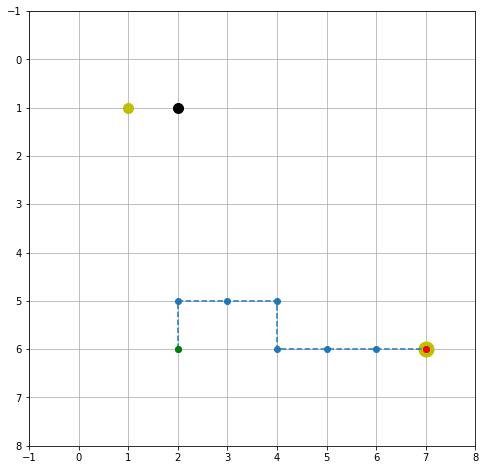

In [731]:
#traj = episode(ag, env, s=[1,3], eps=0.)
traj = episode(ag, env, eps=0.)
for t in traj:
    print(t['s'])
print(traj[-1]['sp'])

env.draw(traj=traj);

In [661]:
ag.Q[venv.c2i([[0,7]]),:]

array([[24.97125039, 18.3305528 , 18.0013044 , 20.06725828]])